In [1]:
# imports
import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
#####################
# my files
# target model
from net_ import target_net
#from net_conv import target_net
# gan architectures
import gans_archs
# advgan training class
from GAN_ import advGAN

if torch.cuda.is_available():  
    dev = 'cuda:0'
else:  
    dev = 'cpu'

print('device: ', dev)

# functions
def transform_data(data_loader_obj):
    ims = []
    lls = []
    for imgs,lbls in data_loader_obj:
        for img,lbl in zip(imgs,lbls):
            ims.append(img)
            lls.append(lbl)
    ims = torch.stack(ims)
    lls = torch.stack(lls)
    return ims,lls

def show_tensor_images(image_tensor, num_images=25):
    image_tensor = image_tensor.reshape(image_tensor.shape[0],1,28,28).cpu().detach()
    size = (1,28,28)
    image_unflat = image_tensor.detach().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

device:  cuda:0


In [7]:
# obtain mnist data and process
batch_size = 128
num_of_classes = 10

def get_indices(dataset,ind_array):
    indices =  []
    for i in range(len(dataset.targets)):
        for ind in ind_array:
            if dataset.targets[i] == ind:
                indices.append(i)
    return indices

dataset = MNIST('.', train=True, download=False,transform=transforms.ToTensor())
dataset_test = MNIST('.', train=False, download=False,transform=transforms.ToTensor())

idx = get_indices(dataset, np.arange(num_of_classes))
idx_test = get_indices(dataset_test, np.arange(num_of_classes))

data_loader_rftarget = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
data_loader_target = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
data_loader_gan = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
data_loader_test = DataLoader(dataset_test, batch_size=1000, sampler = SubsetRandomSampler(idx_test))

classes = np.arange(num_of_classes)

In [9]:
# target model
n_estimators = 100
ims_train,lls_train = transform_data(data_loader_rftarget)
rf = RandomForestClassifier(n_estimators=n_estimators)
#rf.fit(ims_train.reshape(len(ims_train),28*28).detach().numpy(),lls_train)
# save the model
PATH = './target_models/rf_model'+str(num_of_classes)+'classes'+'_nest'+str(n_estimators)+'.joblib'
#dump(rf, PATH) 
# load the model
rf = load(PATH)

# test random forest accuracy
ims_test,lls_test = transform_data(data_loader_test)
print('accuracy: ', accuracy_score(rf.predict(ims_test.reshape(len(ims_test),28*28).detach().numpy()),lls_test))

accuracy:  0.9701


In [10]:
# train distilled neural network on output from random forest
net = target_net(num_of_classes).to(dev)
criterion_tar = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

path_disttar = './target_models/ff_net_distilled_100est_'+str(num_of_classes)+'classes_device-'+dev+'.pth'
# train and and save the model
#net.train(data_loader_target, criterion_tar, optimizer, dev, master_model=rf.predict)
#torch.save(net.state_dict(), path_disttar)
# load the model
net = target_net(num_of_classes).to(dev)
net.load_state_dict(torch.load(path_disttar))

print('model accuracy: ', net.accuracy(data_loader_test,dev))

model accuracy:  97.63


In [11]:
# import gen/disc
gen = gans_archs.Generator1()
disc = gans_archs.Discriminator1()

# arguments for GAN training 
tar_criterion=nn.CrossEntropyLoss()
criterion=nn.BCEWithLogitsLoss()
n_epochs=200
batch_size=128
lr=0.00001
device=dev
display_step=500
gen_arch='cov'
###############################
gen_arch_num=1
disc_coeff=2150.
hinge_coeff=180.
adv_coeff=900.
c=0.2
gen_path_extra='distilledrf_genarch_100est_'+str(gen_arch_num)
shape=(1,28,28)
num_of_classes=num_of_classes
################################

# things to investigate
'''
add noise vector in generator
change to 0-1 loss ? 
'''

# initiate advgan
advgan = advGAN(net,gen,disc,tar_criterion=tar_criterion,
                criterion=criterion,n_epochs=n_epochs,
                batch_size=batch_size,num_of_classes=num_of_classes,
                lr=lr,disc_coeff=disc_coeff,hinge_coeff=hinge_coeff,
                adv_coeff=adv_coeff,c=c,gen_path_extra=gen_path_extra,
                device=device,display_step=display_step,shape=shape,gen_arch=gen_arch)

path:  ./advgan_models/distilledrf_genarch_100est_1_device_cuda:0_10classes_2150p0disc_180p0hinge_0p2c_900p0adv.pt


In [ ]:
%%time 
# train the gan
#gen,disc = advgan.train(data_loader_gan)

In [12]:
# load the generator 
path = advgan.gen_path
full_path = path[0:15] + '/models_keep' + path[15::]
gen = advgan.load_gen(full_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


advGAN Attack
rf accuracy (clean):  0.9700999999999999
nn accuracy (clean):  0.9765
% adv rf (out of nn adv examples):  0.6498050855357576
% adv nn:  0.9608
avg. noise (L2):  1.9424641370773315


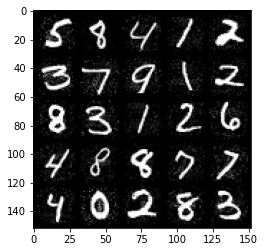

In [13]:
# test transferability from adv examples for the nn to the rf
counter = 0.
total_rf_clean = 0.
total_nn_clean = 0.
total_rf_adv = 0.
total_nn_adv = 0.
lengths = 0.
totals = 0.
perts =.0
for data,label in data_loader_test:
    rf_output_clean = rf.predict(data.reshape(len(data),28*28).cpu().detach().numpy())
    nn_output_clean = torch.argmax(net(data.reshape(len(data),28*28).to(dev)),dim=1)
    # make adv example
    pert = gen(data.reshape(len(data),28*28).to(dev))
    adv_img = (data.reshape(len(data),28*28).to(dev) + pert).to(dev)
    rf_output_adv = rf.predict(adv_img.cpu().detach().numpy())
    nn_output_adv = torch.argmax(net(adv_img.to(dev)),dim=1)
    #calculate and return accuracy 
    total_rf_clean += accuracy_score(rf_output_clean,label.cpu().detach().numpy())
    total_nn_clean += accuracy_score(nn_output_clean.cpu().detach().numpy(),label.cpu().detach().numpy())
    total_rf_adv += accuracy_score(rf_output_adv[(label.to(dev) != nn_output_adv).cpu()],label[label.to(dev) != nn_output_adv].cpu().detach().numpy())
    total_nn_adv += accuracy_score(nn_output_adv.cpu().detach().numpy(),label.cpu().detach().numpy())
    counter += 1.
    lengths += float(sum(label.to(dev) != nn_output_adv).detach().cpu().numpy())
    totals += len(data)
    perts += torch.mean(torch.norm(pert,dim=1)).detach().cpu().numpy()
    
print('advGAN Attack')
print('rf accuracy (clean): ', total_rf_clean/counter)
print('nn accuracy (clean): ', total_nn_clean/counter)
print('% adv rf (out of nn adv examples): ', 1.-total_rf_adv/counter)
print('% adv nn: ', 1.-total_nn_adv/counter)
print('avg. noise (L2): ',perts/counter)
show_tensor_images(adv_img)

In [15]:
# # load a net w/o the train method (messes up art if it is there)
# from net_ import target_net
# del target_net.train
# net_art = target_net(num_of_classes)
# net_art.load_state_dict(torch.load(path_disttar))

# data to attack
ims_attack,actual_lables = transform_data(data_loader_test)
ims_attack = ims_attack.reshape(ims_attack.shape[0],28*28)

Linf PGD Attack
rf accuracy (clean):  0.9701
nn accuracy (clean):  0.9767
% adv rf (out of nn adv examples):  0.701334463037492
% adv nn:  0.9442
avg. noise (L2):  2.5292599201202393


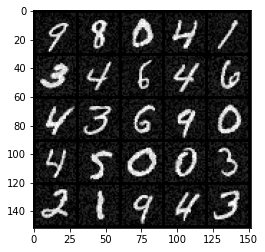

In [16]:
# Linf PGD attack
from advertorch.attacks import LinfPGDAttack

# set up the attack
adversary_LinfPGD = LinfPGDAttack(
    net, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.15,
    nb_iter=40, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=True)

# target and run
target = (actual_lables + 1)%10    # same type of attack as advgan
pgd_advex = adversary_LinfPGD.perturb(ims_attack.to(dev), target.to(dev))

# model output
rf_output_clean = rf.predict(ims_attack)
nn_output_clean = torch.argmax(net(ims_attack.to(dev)),dim=1)
rf_output_adv = rf.predict(pgd_advex.cpu().detach().numpy())
nn_output_adv = torch.argmax(net(pgd_advex),dim=1)
    
# calculate and return accuracy 
acc_rf_clean = accuracy_score(rf_output_clean,actual_lables)
acc_nn_clean = accuracy_score(nn_output_clean.cpu().detach().numpy(),actual_lables)
# test transferability on ONLY the ones which failed for the NN
acc_rf_adv = accuracy_score(rf_output_adv[(nn_output_adv != actual_lables.to(dev)).cpu()],actual_lables[nn_output_adv != actual_lables.to(dev)].cpu())   #########
acc_nn_adv = accuracy_score(nn_output_adv.cpu().detach().numpy(),actual_lables)

print('Linf PGD Attack')
print('rf accuracy (clean): ', acc_rf_clean)
print('nn accuracy (clean): ', acc_nn_clean)
print('% adv rf (out of nn adv examples): ', 1.-acc_rf_adv)
print('% adv nn: ', 1.-acc_nn_adv)
print('avg. noise (L2): ',float(torch.mean(torch.norm(pgd_advex.cpu()-ims_attack,dim=1)).detach().cpu().numpy()))
show_tensor_images(pgd_advex)

In [17]:
# CW attack
from advertorch.attacks import CarliniWagnerL2Attack

# set up the attack
adversary_LinfPGD = CarliniWagnerL2Attack(net, 10, confidence=0,
                 targeted=True, learning_rate=0.01,
                 binary_search_steps=9, max_iterations=10000,
                 abort_early=True, initial_const=1e-3,
                 clip_min=0., clip_max=1.)

# target and run
target = (actual_lables + 1)%10    # same type of attack as advgan
cw_advex = adversary_LinfPGD.perturb(ims_attack.to(dev), target.to(dev))

# model output
rf_output_clean = rf.predict(ims_attack)
nn_output_clean = torch.argmax(net(ims_attack.to(dev)),dim=1)
rf_output_adv = rf.predict(cw_advex.cpu().detach().numpy())
nn_output_adv = torch.argmax(net(cw_advex),dim=1)
    
# calculate and return accuracy 
acc_rf_clean = accuracy_score(rf_output_clean,actual_lables)
acc_nn_clean = accuracy_score(nn_output_clean.cpu().detach().numpy(),actual_lables)
# test transferability on ONLY the ones which failed for the NN
acc_rf_adv = accuracy_score(rf_output_adv[(nn_output_adv != actual_lables.to(dev)).cpu()],actual_lables[nn_output_adv != actual_lables.to(dev)].cpu())   #########
acc_nn_adv = accuracy_score(nn_output_adv.cpu().detach().numpy(),actual_lables)

print('CW Attack')
print('rf accuracy (clean): ', acc_rf_clean)
print('nn accuracy (clean): ', acc_nn_clean)
print('% adv rf (out of nn adv examples): ', 1.-acc_rf_adv)
print('% adv nn: ', 1.-acc_nn_adv)
print('avg. noise (L2): ',float(torch.mean(torch.norm(cw_advex.cpu()-ims_attack,dim=1)).detach().cpu().numpy()))
show_tensor_images(cw_advex)

KeyboardInterrupt: 

FGSM Attack
rf accuracy (clean):  0.9701
nn accuracy (clean):  0.9767
% adv rf (out of nn adv examples):  0.7153433750319123
% adv nn:  0.39170000000000005
avg. noise (L2):  6.122495651245117


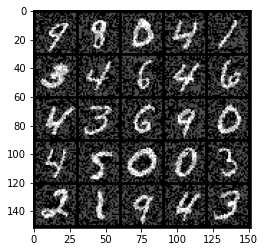

In [18]:
# FGSM attack
from advertorch.attacks import GradientSignAttack

# set up the attack
adversary_FGSM = GradientSignAttack(net, loss_fn=nn.CrossEntropyLoss(), eps=0.3, clip_min=0.,
                 clip_max=1., targeted=True)

# target and run
target = (actual_lables + 1)%10    # same type of attack as advgan
fgsm_advex = adversary_FGSM.perturb(ims_attack.to(dev), target.to(dev))

# model output
rf_output_clean = rf.predict(ims_attack)
nn_output_clean = torch.argmax(net(ims_attack.to(dev)),dim=1)
rf_output_adv = rf.predict(fgsm_advex.cpu().detach().numpy())
nn_output_adv = torch.argmax(net(fgsm_advex),dim=1)
    
# calculate and return accuracy 
acc_rf_clean = accuracy_score(rf_output_clean,actual_lables)
acc_nn_clean = accuracy_score(nn_output_clean.cpu().detach().numpy(),actual_lables)
# test transferability on ONLY the ones which failed for the NN
acc_rf_adv = accuracy_score(rf_output_adv[(nn_output_adv != actual_lables.to(dev)).cpu()],actual_lables[nn_output_adv != actual_lables.to(dev)].cpu())   #########
acc_nn_adv = accuracy_score(nn_output_adv.cpu().detach().numpy(),actual_lables)

print('FGSM Attack')
print('rf accuracy (clean): ', acc_rf_clean)
print('nn accuracy (clean): ', acc_nn_clean)
print('% adv rf (out of nn adv examples): ', 1.-acc_rf_adv)
print('% adv nn: ', 1.-acc_nn_adv)
print('avg. noise (L2): ',float(torch.mean(torch.norm(fgsm_advex.cpu()-ims_attack,dim=1)).detach().cpu().numpy()))
show_tensor_images(fgsm_advex)

CW Attack
rf accuracy (clean):  1.0
nn accuracy (clean):  0.98
% adv rf (out of nn adv examples):  0.4137931034482759
% adv nn:  0.5800000000000001
avg. noise (L2):  1.1449226140975952


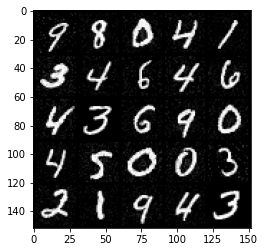

In [19]:
# CW attack
from advertorch.attacks import CarliniWagnerL2Attack

# set up the attack
adversary_CW = CarliniWagnerL2Attack(net, 10, confidence=0.7,
                 targeted=True, learning_rate=0.01,
                 binary_search_steps=1075, max_iterations=12500,
                 abort_early=True, initial_const=1e-2,
                 clip_min=0., clip_max=1.)

# new data for testing 
TEST_x = ims_attack[0:50]
TEST_lbl = actual_lables[0:50]

# target and run
target = (TEST_lbl + 1)%10    # same type of attack as advgan
cw_advex = adversary_CW.perturb(TEST_x.to(dev), target.to(dev))

# model output
rf_output_clean = rf.predict(TEST_x)
nn_output_clean = torch.argmax(net(TEST_x.to(dev)),dim=1)
rf_output_adv = rf.predict(cw_advex.cpu().detach().numpy())
nn_output_adv = torch.argmax(net(cw_advex),dim=1)
    
# calculate and return accuracy 
acc_rf_clean = accuracy_score(rf_output_clean,TEST_lbl)
acc_nn_clean = accuracy_score(nn_output_clean.cpu().detach().numpy(),TEST_lbl)
# test transferability on ONLY the ones which failed for the NN
acc_rf_adv = accuracy_score(rf_output_adv[(nn_output_adv != TEST_lbl.to(dev)).cpu()],TEST_lbl[nn_output_adv != TEST_lbl.to(dev)].cpu())   #########
acc_nn_adv = accuracy_score(nn_output_adv.cpu().detach().numpy(),TEST_lbl)

print('CW Attack')
print('rf accuracy (clean): ', acc_rf_clean)
print('nn accuracy (clean): ', acc_nn_clean)
print('% adv rf (out of nn adv examples): ', 1.-acc_rf_adv)
print('% adv nn: ', 1.-acc_nn_adv)
print('avg. noise (L2): ',float(torch.mean(torch.norm(cw_advex.cpu()-TEST_x,dim=1)).detach().cpu().numpy()))
show_tensor_images(cw_advex)

In [ ]:
# ##### FGM

# # ART torch classifier model
# from art.estimators.classification import PyTorchClassifier
# classifier = PyTorchClassifier(
#     model=net_art,
#     clip_values=(0, 1),
#     loss=criterion_tar,
#     optimizer=optimizer,
#     input_shape=(28*28,),
#     nb_classes=num_of_classes)

# # transferability of FGM attack
# from art.attacks.evasion import FastGradientMethod
# attack = FastGradientMethod(estimator=classifier, eps=1./11.)
# x_fgm_adv = attack.generate(x=ims_attack)

# # model output
# rf_output_clean = rf.predict(ims_attack)
# nn_output_clean = torch.argmax(net_art(ims_attack.to(dev)),dim=1)
# rf_output_adv = rf.predict(x_fgm_adv)
# nn_output_adv = torch.argmax(net_art(torch.from_numpy(x_fgm_adv).to(dev)),dim=1)
    
# # calculate and return accuracy 
# acc_rf_clean = accuracy_score(rf_output_clean,actual_lables)
# acc_nn_clean = accuracy_score(nn_output_clean.cpu().detach().numpy(),actual_lables)
# # test transferability on ONLY the ones which failed for the NN
# acc_rf_adv = accuracy_score(rf_output_adv[(nn_output_adv != actual_lables.to(dev)).cpu()],actual_lables[nn_output_adv != actual_lables.to(dev)].cpu())   #########
# acc_nn_adv = accuracy_score(nn_output_adv.cpu().detach().numpy(),actual_lables)

# print('FGSM Attack')
# print('rf accuracy (clean): ', acc_rf_clean)
# print('nn accuracy (clean): ', acc_nn_clean)
# print('% adv rf (out of nn adv examples): ', 1.-acc_rf_adv)
# print('% adv nn: ', 1.-acc_nn_adv)
# print('avg. noise (L2): ',float(torch.mean(torch.norm(torch.from_numpy(x_fgm_adv)-ims_attack,dim=1)).detach().cpu().numpy()))
# show_tensor_images(torch.from_numpy(x_fgm_adv))

In [ ]:
# ##### CW

# # ART torch classifier model
# from art.estimators.classification import PyTorchClassifier
# from art.attacks.evasion import CarliniL2Method,CarliniLInfMethod

# classifier = PyTorchClassifier(
#     model=net_art,
#     clip_values=(0, 1),
#     loss=criterion_tar,
#     optimizer=optimizer,
#     input_shape=(28*28,),
#     nb_classes=num_of_classes)

# # this attack takes a long time, so for initial experiments, lets just use a subset of the data
# k = 100
# imgs_attack = ims_attack[0:k]
# actual_lbls= actual_lables[0:k]

# # transferability of CW attack
# attack = CarliniL2Method(classifier)
# CW_adv_img = attack.generate(x=imgs_attack,y=((actual_lbls+1)%2))
# np.save('./target_models/CW_adv_img.npy',CW_adv_img)
# #CW_adv_img = np.load('./target_models/CW_adv_img.npy')

# # model output
# rf_output_clean = rf.predict(imgs_attack)
# nn_output_clean = torch.argmax(net_art(imgs_attack.to(dev)),dim=1)
# rf_output_adv = rf.predict(CW_adv_img)
# nn_output_adv = torch.argmax(net_art(torch.from_numpy(CW_adv_img).to(dev)),dim=1)

# # calculate and return accuracy 
# acc_rf_clean = accuracy_score(rf_output_clean,actual_lbls)
# acc_nn_clean = accuracy_score(nn_output_clean.cpu().detach().numpy(),actual_lbls)
# acc_rf_adv = accuracy_score(rf_output_adv[nn_output_adv.detach().cpu() != actual_lbls],actual_lbls[nn_output_adv.detach().cpu() != actual_lbls])
# acc_nn_adv = accuracy_score(nn_output_adv.cpu().detach().numpy(),actual_lbls)

# print('CW Attack')
# print('rf accuracy (clean): ', acc_rf_clean)
# print('nn accuracy (clean): ', acc_nn_clean)
# print('% adv rf (out of nn adv examples): ', 1.-acc_rf_adv)
# print('% adv nn: ', 1.-acc_nn_adv)
# print('avg. pert (L2): ',float(torch.mean(torch.norm(torch.from_numpy(CW_adv_img)-imgs_attack,dim=1)).detach().cpu().numpy()))
# show_tensor_images(torch.from_numpy(CW_adv_img))

In [ ]:
# comparing to noisy data (normal dist noise)
noise = (1./14.)*torch.normal(0,1,ims_attack.shape)
imgs_noisey = ims_attack + noise

# model output
rf_output_clean = rf.predict(ims_attack)
nn_output_clean = torch.argmax(net(ims_attack.to(dev)),dim=1)
rf_output_adv = rf.predict(imgs_noisey.detach().cpu().numpy())
nn_output_adv = torch.argmax(net(imgs_noisey.to(dev)),dim=1)

# calculate and return accuracy 
acc_rf_clean = accuracy_score(rf_output_clean,actual_lables)
acc_nn_clean = accuracy_score(nn_output_clean.cpu().detach().numpy(),actual_lables)
# test transferability on ONLY the ones which failed for the NN
acc_rf_adv = accuracy_score(rf_output_adv[nn_output_adv.detach().cpu() != actual_lables],actual_lables[nn_output_adv.detach().cpu() != actual_lables])   #########
acc_nn_adv = accuracy_score(nn_output_adv.cpu().detach().numpy(),actual_lables)

print('Random Noise')
print('rf accuracy (clean): ', acc_rf_clean)
print('nn accuracy (clean): ', acc_nn_clean)
print('% missclass rf (out of nn missclass examples): ', 1.-acc_rf_adv)
print('% misclass nn: ', 1.-acc_nn_adv)
print('avg. noise (L2): ',float(torch.mean(torch.norm(noise,dim=1)).detach().cpu().numpy()))
show_tensor_images(imgs_noisey)